<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6
### <center> Beating benchmarks in "How good is your Medium article?"
    
[Competition](https://www.kaggle.com/c/how-good-is-your-medium-article). The task is to beat "Assignment 6 baseline".

In [1]:
import os
import json
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import Ridge
#https://www.kaggle.com/artgor/eda-feature-engineering-and-xgb-lgb

The following code will help to throw away all HTML tags from an article content.

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

Supplementary function to read a JSON line without crashing on escape characters.

In [3]:
def read_json_line(line=None):
    result = None
    try:        
        result = json.loads(line)
    except Exception as e:      
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))      
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)     
        return read_json_line(line=new_line)
    return result

<font color='red'>Extract features `content`, `published`, `title` and `author`, write them to separate files for train and test sets.</font>

In [4]:
def extract_features_and_write(path_to_data,
                               inp_filename, is_train=True):
    
    features = ['content', 'published', 'title', 'author']
    prefix = 'train' if is_train else 'test'
    feature_files = [open(os.path.join(path_to_data,
                                       '{}_{}.txt'.format(prefix, feat)),
                          'w', encoding='utf-8')
                     for feat in features]
    
    
    with open(os.path.join(path_to_data, inp_filename), 
              encoding='utf-8') as inp_json_file:

        i = 0
        for line in tqdm_notebook(inp_json_file):
            json_data = read_json_line(line)

            i +=1
            # You code here
            
            for idx, feature in enumerate(features):
                data = json_data[feature]
                if feature == 'title':
                    content = data.replace('\n', ' ').replace('\r', ' ')
                    content_no_html_tags = strip_tags(content)
                    feature_files[idx].write(content_no_html_tags+'\n')
                if feature == 'published':
                    val = data['$date']
                    feature_files[idx].write((val + '\n') if val is not None else  '\n')
                if feature == 'author':
                    val = data['twitter']
                    feature_files[idx].write((val + '\n') if val is not None else  '\n')
                if feature == 'content':
                    content = data.replace('\n', ' ').replace('\r', ' ')
                    content_no_html_tags = strip_tags(content)
                    feature_files[idx].write(content_no_html_tags+'\n')
            #if i > 2:
            #    break

In [5]:
PATH_TO_DATA = '../../data' # modify this if you need to

In [6]:
extract_features_and_write(PATH_TO_DATA, 'train.json', is_train=True)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [7]:
extract_features_and_write(PATH_TO_DATA, 'test.json', is_train=False)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

**Add the following groups of features:**
    - Tf-Idf with article content (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Tf-Idf with article titles (ngram_range=(1, 2), max_features=100000 but you can try adding more)
    - Time features: publication hour, whether it's morning, day, night, whether it's a weekend
    - Bag of authors (i.e. One-Hot-Encoded author names)

In [8]:
%%time
def file_to_list(file_name):
    content = []
    with open(file_name, encoding='utf-8') as f:
        content = f.readlines()
        # you may also want to remove whitespace characters like `\n` at the end of each line
        content = [x.strip() for x in content] 
    return content



X_train_content = file_to_list(PATH_TO_DATA+'/train_content.txt')
X_train_title = file_to_list(PATH_TO_DATA+'/train_title.txt')
X_train_author = file_to_list(PATH_TO_DATA+'/train_author.txt')
X_train_time = file_to_list(PATH_TO_DATA+'/train_published.txt')

X_test_content = file_to_list(PATH_TO_DATA+'/test_content.txt')
X_test_title = file_to_list(PATH_TO_DATA+'/test_title.txt')
X_test_author = file_to_list(PATH_TO_DATA+'/test_author.txt')
X_test_time = file_to_list(PATH_TO_DATA+'/test_published.txt')

CPU times: user 2.19 s, sys: 848 ms, total: 3.04 s
Wall time: 3.04 s


In [9]:
%%time

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler


def ohe(values):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    
    onehot_encoder = OneHotEncoder(sparse=True)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    return onehot_encoder.fit_transform(integer_encoded)

# You code here
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000, max_df=0.5)
#train

idx_split = len(X_train_content)

X_full_tarin_content = X_train_content
X_full_tarin_content.extend(X_test_content)

X_full_tarin_content_length = [len(text) for text in X_full_tarin_content]
scaler = StandardScaler()
X_full_tarin_content_length_scalled = scaler.fit_transform(np.asarray(X_full_tarin_content_length).reshape((len(X_full_tarin_content_length),1)))




X_full_tarin_title = np.hstack([X_train_title, X_test_title])
X_full_tarin_author = np.hstack([X_train_author, X_test_author])
print(len(X_full_tarin_content))
print(len(X_full_tarin_title))
print(len(X_full_tarin_author))
print(X_full_tarin_content_length_scalled.shape)

96958
96958
96958
(96958, 1)
CPU times: user 72 ms, sys: 8 ms, total: 80 ms
Wall time: 79.8 ms


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [10]:
%%time
X_full_tarin_content_sparse = vectorizer.fit_transform(X_full_tarin_content)
X_full_tarin_title_sparse = vectorizer.fit_transform(X_full_tarin_title)


/usr/local/lib/python3.5/dist-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


CPU times: user 8min 28s, sys: 11.1 s, total: 8min 39s
Wall time: 8min 52s


In [11]:
%%time
X_full_tarin_author_sparse = ohe(X_full_tarin_author)

CPU times: user 40 ms, sys: 8 ms, total: 48 ms
Wall time: 143 ms


In [12]:
X_train_content_sparse = X_full_tarin_content_sparse[:idx_split, :]
X_train_title_sparse = X_full_tarin_title_sparse[:idx_split, :]
X_train_author_sparse = X_full_tarin_author_sparse[:idx_split, :]
X_train_content_length_scalled = X_full_tarin_content_length_scalled[:idx_split, :]

X_test_content_sparse = X_full_tarin_content_sparse[idx_split:,:]
X_test_title_sparse = X_full_tarin_title_sparse[idx_split:,:]
X_test_author_sparse = X_full_tarin_author_sparse[idx_split:,:]
X_test_content_length_scalled = X_full_tarin_content_length_scalled[idx_split:,:]


print(X_train_content_sparse.shape)
print(X_train_title_sparse.shape)
print(X_train_author_sparse.shape)

print(X_test_content_sparse.shape)
print(X_test_title_sparse.shape)
print(X_test_author_sparse.shape)

print(X_train_content_length_scalled.shape)
print(X_test_content_length_scalled.shape)

# #-----------------------
# X_train_content_sparse = vectorizer.fit_transform(X_train_content)
# X_train_title_sparse = vectorizer.fit_transform(X_train_title)
# X_train_author_sparse = ohe(X_train_author)

# #test
# X_test_content_sparse = vectorizer.fit_transform(X_test_content)
# X_test_title_sparse = vectorizer.fit_transform(X_test_title)
# X_test_author_sparse = ohe(X_test_author)

(62313, 100000)
(62313, 100000)
(62313, 31199)
(34645, 100000)
(34645, 100000)
(34645, 31199)
(62313, 1)
(34645, 1)


In [13]:
#TIME TIME

In [14]:
%%time
from datetime import datetime
import dateutil.parser

def str_to_date(val):
    return datetime.strptime(val[:19], "%Y-%m-%dT%H:%M:%S")

X_train_time_vals = [str_to_date(date) for date in X_train_time]
X_test_time_vals = [str_to_date(date) for date in X_test_time]




CPU times: user 856 ms, sys: 0 ns, total: 856 ms
Wall time: 898 ms


In [15]:
#print(X_train_time_vals[0].weekday())
#print(X_test_time_vals[0].day)

X_train_time_morning = [int(t.hour < 11) for t in X_train_time_vals]
X_train_time_weekend = [int(t.weekday() >= 6) for t in X_train_time_vals]
X_train_time_hour = [t.hour for t in X_train_time_vals]
X_train_time_day = [t.day for t in X_train_time_vals]
X_train_time_day_night = [int((t.hour >= 11) & (t.hour <= 19)) for t in X_train_time_vals]



X_test_time_morning = [int(t.hour < 11) for t in X_test_time_vals]
X_test_time_weekend = [int(t.weekday() >= 6) for t in X_test_time_vals]
X_test_time_hour = [t.hour for t in X_test_time_vals]
X_test_time_day = [t.day for t in X_test_time_vals]
X_test_time_day_night = [int((t.hour >= 11) & (t.hour <= 19)) for t in X_test_time_vals]




X_train_time_morning = np.asarray(X_train_time_morning).reshape((62313,1))
X_train_time_weekend = np.asarray(X_train_time_weekend).reshape((62313,1))
X_train_time_hour = np.asarray(X_train_time_hour).reshape((62313,1))
X_train_time_day = np.asarray(X_train_time_day).reshape((62313,1))
X_train_time_day_night = np.asarray(X_train_time_day_night).reshape((62313,1))


X_test_time_morning = np.asarray(X_test_time_morning).reshape((34645,1))
X_test_time_weekend = np.asarray(X_test_time_weekend).reshape((34645,1))
X_test_time_hour = np.asarray(X_test_time_hour).reshape((34645,1))
X_test_time_day = np.asarray(X_test_time_day).reshape((34645,1))
X_test_time_day_night = np.asarray(X_test_time_day_night).reshape((34645,1))

In [16]:
X_train_time_hour_OHE = ohe(X_train_time_hour)
X_test_time_hour_OHE = ohe(X_test_time_hour)

X_train_time_day_OHE = ohe(X_train_time_day)
X_test_time_day_OHE = ohe(X_test_time_day)


print(X_train_time_morning.shape)
print(X_train_time_weekend.shape)
print(X_train_time_hour_OHE.shape)


(62313, 1)
(62313, 1)
(62313, 24)


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
#JOIN ALL TIME FEATURES
X_train_time_features_sparse = hstack([X_train_time_morning, 
                                       X_train_time_weekend, 
                                       X_train_time_day_night, 
                                       X_train_time_day_OHE, 
                                       X_train_content_length_scalled])

X_test_time_features_sparse = hstack([X_test_time_morning, 
                                      X_test_time_weekend, 
                                      X_test_time_day_night, 
                                      X_test_time_day_OHE, 
                                      X_test_content_length_scalled])

In [18]:
print(X_train_time_features_sparse.shape)
print(X_test_time_features_sparse.shape)

(62313, 35)
(34645, 35)


**Join all sparse matrices.**

In [19]:
X_train_sparse = csr_matrix(hstack([X_train_content_sparse, X_train_title_sparse,
                                    X_train_author_sparse, X_train_time_features_sparse]))

In [20]:
X_test_sparse = csr_matrix(hstack([X_test_content_sparse, X_test_title_sparse,
                                    X_test_author_sparse, X_test_time_features_sparse]))

**Read train target and split data for validation.**

In [21]:
train_target = pd.read_csv('../../data/train_log1p_recommends.csv', 
                           index_col='id')
y_train = train_target['log_recommends'].values

In [22]:
train_part_size = int(0.7 * train_target.shape[0])
X_train_part_sparse = X_train_sparse[:train_part_size, :]
y_train_part = y_train[:train_part_size]

X_valid_sparse =  X_train_sparse[train_part_size:, :]
y_valid = y_train[train_part_size:]

**Train a simple Ridge model and check MAE on the validation set.**

In [23]:
%%time
# You code here



ridge = Ridge(random_state=17, alpha=0.16)
ridge.fit(X_train_part_sparse, y_train_part);

CPU times: user 3min 23s, sys: 1.22 s, total: 3min 24s
Wall time: 3min 25s


In [24]:
%%time
ridge_pred = ridge.predict(X_valid_sparse)
valid_mae = mean_absolute_error(y_valid, ridge_pred)
print(valid_mae, np.expm1(valid_mae))

# valid_mae2 = mean_absolute_error(ridge_pred,np.zeros_like(y_valid))
# print(valid_mae2, np.expm1(valid_mae2))


1.0802097619556512 1.9452972975945164
CPU times: user 64 ms, sys: 0 ns, total: 64 ms
Wall time: 484 ms


**Train the same Ridge with all available data, make predictions for the test set and form a submission file.**

In [25]:
%%time
# You code here


ridge.fit(X_train_sparse, y_train);



CPU times: user 4min 33s, sys: 1.62 s, total: 4min 34s
Wall time: 4min 35s


Ridge(alpha=0.16, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=17, solver='auto', tol=0.001)

In [26]:
print(X_train_sparse.shape)
print(X_test_sparse.shape)

(62313, 231234)
(34645, 231234)


In [27]:
ridge_test_pred = ridge.predict(X_test_sparse)

In [28]:
def write_submission_file(prediction, filename, path_to_sample='../../data/sample_submission (1).csv'):
    submission = pd.read_csv(path_to_sample, index_col='id')
    
    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [29]:
#write_submission_file(ridge_test_pred, 'assignment6_medium_submission.csv')

**Now's the time for dirty Kaggle hacks. Form a submission file with all zeroes. Make a submission. What do you get if you think about it? How is it going to help you with modifying your predictions?**

In [30]:
# write_submission_file(np.zeros_like(ridge_test_pred), 
#                       'medium_all_zeros_submission.csv')

**Modify predictions in an appropriate way (based on your all-zero submission) and make a new submission.**

In [86]:
ridge_test_pred_modif = [((v+1.227354) if v > 0 else 0) for v in ridge_test_pred]
#ridge_test_pred_modif = [v*1.395164 for v in ridge_test_pred]

In [87]:
write_submission_file(ridge_test_pred_modif, 
                      'assignment6_medium_submission_with_hack.csv')

In [67]:
print(np.min(ridge_test_pred))

-0.3113313566415372


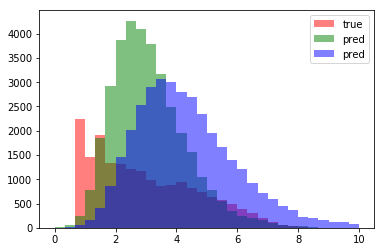

In [34]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_test_pred, bins=30, alpha=.5, color='green', label='pred', range=(0,10));
plt.hist(ridge_test_pred*1.3973, bins=30, alpha=.5, color='blue', label='pred', range=(0,10));

plt.legend();

In [35]:
print(np.percentile(ridge_test_pred, 50))

2.93251068920344


In [88]:
print(np.mean(ridge_test_pred))

3.105930493711545


In [84]:
print(np.mean(ridge_test_pred+1.227354))

4.333284493711545


In [68]:
print(np.std(ridge_test_pred+1.395164))

1.2024295769096367


In [39]:
np.log(2.58976)

0.9515652073252

In [85]:
np.sum(np.abs(ridge_test_pred+1.227354))

150126.64128463648